# Boosting

Boostring(부스팅)은 약한 learner(학습기)를 여러 개 연결하여 강한 학습기를 만드는 ensemble 기법이다. Boosting의 main idea는 **앞의 모델을 보완**해나가면서 일련의 learn(학습기)를 학습시키는 것이다. 어떤 방법으로 보완을 할까? 앞으로 살펴보도록 하자.

Boostring의 종류
* AdaBoost(아다부스트, Adaptive Boostring)
* Gradient Boostring(그레디언트 부스팅)
* XGBoost
* CatBoost

In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# Classifer를 입력으로 받고, 결정경계를 그려주는 Help 함수 입니다.
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

## 7.1 AdaBoost
* 이전 learner(학습기)를 보완하는 새로운 학습기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이다. 이렇게 하면 새로운 학습기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.
    * 아다부스트 분류기를 만들려면 기반이 되는 첫 번째 분류기(예를 들어 결정 트리)를 훈련 세트에서 훈련시키고 예측을 만든다.
    * 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
    * 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다.

그림 추가

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

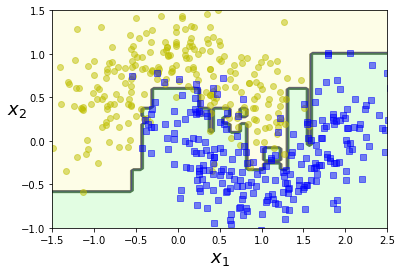

In [9]:
plot_decision_boundary(ada_clf, X, y)

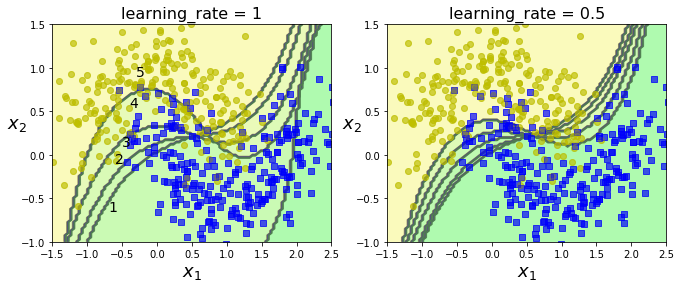

In [13]:
from sklearn.svm import SVC

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

Moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계이다. (이 모델은 규제를 강하게 한 RBF 커널 SVM 분류기이다.) 첫 번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌다. 따라서 두 번째 분류기는 이 샘플들을 더 정확히 예측하게 된다.

오른쪽 그래느는 학습률을 반으로 낮춘 것만 빼고 똑같은 일련의 예측기를 나타낸 것이다. (즉, 잘못 분류된 샘플의 가중치는 반복마다 절반 정도만 높아진다.)

이런 연속된 학습 기법은 경사 하갑법과 비슷한 면이 존재한다. 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 아다부스트는 점차 더 좋아지록 앙상블에 예측기를 추가한다.